In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from astropy.io import ascii
from sklearn.linear_model import LinearRegression
import seaborn as sns

data = ascii.read('Cepheids_DATA_all.csv')

y=data['MV']
x=data['LogP']

### The Period-Luminosity Relation of Cepheids

Cepheid variable stars are one of the best tools astronomers have to measure distances. See [here](https://community.dur.ac.uk/physics.astrolab/cepheid.html) for example.
The observed fluxes of Cepheid stars varies periodically, and the period of this variation is found to correlate with the intrinsic luminosity of the stars. 
The physical reason for this behavor is that the apparent increase in brightness is due to a change in radius and surface temperature.

These stars are optimal distance indicators because 1) they are easilky recongnisable, 2) they very bright, thus can be seen to great distances and 3) the relation between the period and luminosity is well defined. 
This latter property was discovered in 1908 by Henrietta Leavitt from her study of 1000s of variable stars in the Magellanic Clouds.

The sample of Cepheid stars comes from [this paper](https://www.aanda.org/articles/aa/full_html/2018/11/aa33478-18/aa33478-18.html). The distances to the Cepheids comes from [Gaia DR2](http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=I%2F347%2Fgaia2dis). The list of objects was cross-matched with the  Bailer-Jones et al (2018) table using a radius of 1.5". I used [Vizier](http://cdsxmatch.u-strasbg.fr/#tab=xmatch&) to perform the cross match.




Number of data points =  203


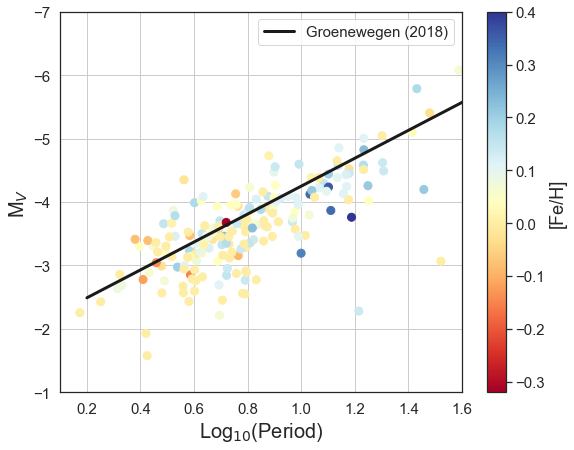

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import betabinom
from scipy.stats import binom
from scipy.stats import beta
from scipy.stats import gamma
from scipy.stats import invgamma
from scipy.stats import nbinom
from scipy.stats import norm
from scipy.stats import poisson
from scipy.stats import t
from astropy.io import fits
from astropy.io import ascii
cm = plt.cm.get_cmap('RdYlBu')

data = ascii.read('Cepheid_data.csv')

MV=data['Vmag']- 5*np.log10(data['rest']) +5 -3.1*data['E_B-V_']
dist_range=0.5*(data['B_rest'] - data['b_rest'])
plot= (data['rest']>7.*dist_range)&(data['angDist']<0.1)
plt.figure(figsize=(9, 7))

sc = plt.scatter(np.log10(data['Period'][plot]),MV[plot],c=data['__Fe_H_3'][plot],s=65,cmap=cm)
cbar=plt.colorbar(sc)
cbar.ax.tick_params(labelsize=15) 
cbar.set_label(label='[Fe/H]',size=18)

logP = np.arange(0.2,2.,0.1)
plt.plot(logP,-2.2*logP-2.05,lw=3,color='k',label='Groenewegen (2018)')
plt.ylim(-1,-7)
plt.xlim(0.1,1.6)
plt.legend(fontsize=15)


plt.xlabel(r'Log$_{10}$(Period)',fontsize=20)
plt.ylabel(r'M$_V$',fontsize=20)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)
plt.grid()

print('Number of data points = ',len(data['Period'][plot]))

We want to fit a linear model to the data. 
We will use the following linear model:

$Y_i = \beta x_i + \epsilon_i$

where $\epsilon_i$ are iid N(0,$\lambda^{-1}$).

Thinking of what we discussed in lecture, we consider the random variables

$Y_i$ where i=1,...,n 

and 

$X_i=(1,X_{i2},....,X_{ip})$. 

What are p and n in this case?

If we assume that $Y_i|x_i,\beta,\lambda \sim N(x_i\beta,\lambda^{-1})$ then Likelyhood can be written as: 

$$L(\beta,\lambda) = \lambda^{n/2}\exp{(-\frac{\lambda}{2}(Y-X\beta)^T(Y-X\beta))}$$

Where X is an n$\times$p matrix having ith row of $x_i$.

The frequentist MLE estimator for $\beta$ is:

$\hat{\beta} = (X^TX)^{-1}X^TY$

Working with matrices in python is similar to R. 

Shape of X (203, 2)
Shape of Y (203,)
Beta: [[-2.00406472 -1.95007211]]


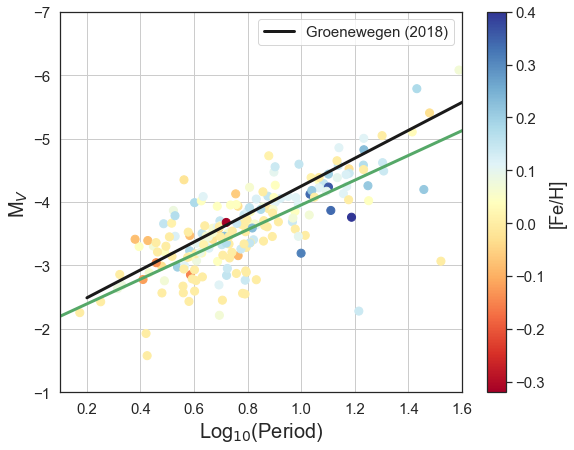

In [35]:
# Setup matrices
X = np.matrix([np.ones(x.shape[0]), x]).T

print('Shape of X',X.shape)
print('Shape of Y',y.shape)

#compute the MLE estimator:
p_mat = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

print('Beta:',p_mat)
#define a new X variable for plotting
xx = np.linspace(-0.2, 1.8, 100)
#compute the line
yy = np.array(p_mat[0,0] + p_mat[0,1] * xx)
plt.figure(figsize=(9, 7))

sc = plt.scatter(np.log10(data['Period'][plot]),MV[plot],c=data['__Fe_H_3'][plot],s=65,cmap=cm)
cbar=plt.colorbar(sc)
cbar.ax.tick_params(labelsize=15) 
cbar.set_label(label='[Fe/H]',size=18)

logP = np.arange(0.2,2.,0.1)
plt.plot(logP,-2.2*logP-2.05,lw=3,color='k',label='Groenewegen (2018)')
plt.ylim(-1,-7)
plt.xlim(0.1,1.6)
plt.legend(fontsize=15)


plt.xlabel(r'Log$_{10}$(Period)',fontsize=20)
plt.ylabel(r'M$_V$',fontsize=20)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)
plt.grid()

plt.plot(xx,yy,lw=3,color='g')


# Try it yourself:

Compute the Maximum Likelihood estimator for $\lambda$. 

## Bayesian Linear Regression Using  Reference Prior

The likelihood has not changed, but we use a reference prior $\pi(\beta, \lambda)\propto \lambda^{-1}$. We saw that in this case the joint posterior on the parameters can be written as:


$$q(\beta,\lambda) = q(\beta|\lambda, Y, X)q(\lambda|Y, X)$$

where $\beta|\lambda,Y,X \sim N_p(\hat{\beta},(\lambda X^TX)^{-1})$ and $\lambda|Y,X\sim$Gamma((n−p)/2, $(Y −X\hat{\beta})^T (Y −X\hat{\beta})/2)$

In [36]:
from scipy.stats import gamma
from scipy.stats import multivariate_normal


In [38]:

# compute quantities that we need later
res = (y - p_mat[0,0] - p_mat[0,1] * x)
sse = np.sum(res**2)

#parameters of the Gamma function
a_gamma = (len(y) - 2)/2.
b_gamma = sse/2.

n_real = 10000
lam_vector = np.zeros(n_real)
beta=np.zeros((n_real,2))

for j in range(n_real):
    lam_vector[j] = gamma.rvs(a_gamma, scale=1/b_gamma,size=1) #remember that scipy defines it this way
    s_beta = np.linalg.inv(lam_vector[j]*X.T.dot(X))
    beta[j,:]=multivariate_normal.rvs(mean=np.array([p_mat[0,0],p_mat[0,1]]), cov=s_beta, size=1)
    

      Beta_0   Beta_1  Lambda
Mean -2.01 -1.94  2.82
 5% -2.22 -2.20  2.37
95% -1.79 -1.69  3.29


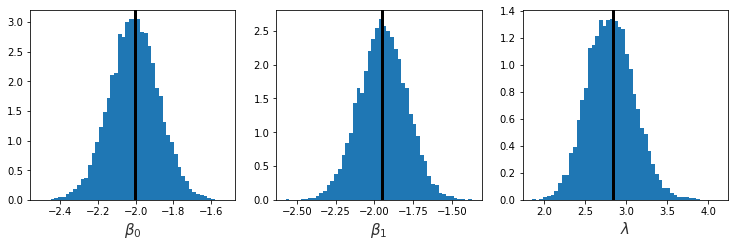

In [15]:
f, [ax1,ax2,ax3] = plt.subplots(1,3,figsize=(12.5, 3.5))
ax1.set_xlabel(r'$\beta_1$',fontsize=15,alpha=0.8)
ax2.set_xlabel(r'$\beta_2$',fontsize=15,alpha=0.8)
ax3.set_xlabel(r'$\lambda$',fontsize=15,alpha=0.8)
ax1.axvline(p_mat[0,0],label='MLE',lw=3,color='k')
ax2.axvline(p_mat[0,1],label='MLE',lw=3,color='k')


ax3.axvline(len(y)/np.sum(res**2),label='MLE',lw=3,color='k')
ax1.hist(beta[:,0],density=True,bins=50)
ax2.hist(beta[:,1],density=True,bins=50)
ax3.hist(lam_vector,density=True,bins=50)

print('      Beta_0   Beta_1  Lambda')
print('Mean {:5.2f} {:5.2f} {:5.2f}'.format(np.mean(beta[:,0]),np.mean(beta[:,1]),np.mean(lam_vector)))
print(' 5% {:5.2f} {:5.2f} {:5.2f}'.format(np.percentile(beta[:,0],5),np.percentile(beta[:,1],5),np.percentile(lam_vector,5)))
print('95% {:5.2f} {:5.2f} {:5.2f}'.format(np.percentile(beta[:,0],95),np.percentile(beta[:,1],95),np.percentile(lam_vector,95)))

## Overplot on the graphs above the theoretical distributions.  